<a href="https://colab.research.google.com/github/leonardtang/NAP/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Create shapes dataset
# Remove corners from each shape and save to new folder
# Remove edges from each shape and save to new folder

In [3]:
!nvidia-smi

Fri Oct 28 14:13:57 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    43W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
import cv2
import numpy as np
import os
import math
import torch
from torch import nn
import argparse
from torchvision import datasets, models, transforms
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
# from meter_utils import AverageMeter, ProgressMeter
import time

classes = [3, 4, 5, 6, 7, 8]
num_per_class = 10000
imgsize = 224
min_radius = 20
thickness = 2
bg_color = (255, 255, 255)
fg_color = (0, 0, 0)
saveto = "./images/shapes/"
corner_hide = 0.3 # Fraction of shape radius, such that a circle of bg_color will be drawn around each corner with this radius to hide the corner
edge_hide = 0.3 # Fraction of shape radius, such that a circle of bg_color will be drawn around center of each edge with this radius to hide the edge

if not os.path.exists(saveto):
    os.makedirs(saveto)

for side in classes:
    for k in tqdm(range(num_per_class)):
        suffix = 'whole' # Save image with suffix to indicate corner_hide, edge_hide, or whole
        # Create a blank image
        img = np.zeros((imgsize, imgsize, 3), np.uint8)
        img[:] = bg_color
        # Randomly select a point on the image
        x = np.random.randint(min_radius + math.ceil(thickness/2) + 1, imgsize-min_radius - math.ceil(thickness/2))
        y = np.random.randint(min_radius + math.ceil(thickness/2) + 1, imgsize-min_radius - math.ceil(thickness/2))
        # Get max radius of polygon
        max_radius = min(x, y, imgsize - x, imgsize - y)
        # Randomly select a radius
        radius = np.random.randint(min_radius, max_radius)
        # Randomly choose a starting angle
        angle = np.random.randint(0, 360)
        angle = angle * np.pi / 180 # Convert to radians
        # Get list of points in polar coordinates
        if side > 2:
            angles = [angle + 2 * np.pi * i / side for i in range(side)]
            points = np.array([(x + radius * np.cos(angle), y + radius * np.sin(angle)) for angle in angles], np.int32)
            # Draw polygon
            img = cv2.polylines(img, [points], True, fg_color, thickness)
            # Save image
            cv2.imwrite(f'{saveto}{side}_{k}_whole.png', img)
            # Make copy of image with corners hidden
            img_nocorners = img.copy()
            for i in range(side):
                cv2.circle(img_nocorners, (points[i][0], points[i][1]), math.ceil(corner_hide * radius), bg_color, -1)
            # Save image
            cv2.imwrite(f'{saveto}{side}_{k}_nocorners.png', img_nocorners)
            # Make copy of image with edges hidden
            img_noedges = img.copy()
            for i in range(side):
                cv2.circle(img_noedges, (int((points[i][0] + points[(i + 1) % side][0]) / 2), int((points[i][1] + points[(i + 1) % side][1]) / 2)), math.ceil(edge_hide * radius), bg_color, -1)
            # Save image
            cv2.imwrite(f'{saveto}{side}_{k}_noedges.png', img_noedges)
        elif side == 1:
            # Draw circle
            img = cv2.circle(img, (x, y), radius, fg_color, thickness)
            # Save image
            cv2.imwrite(f'{saveto}{side}_{k}_whole.png', img)
        else:
            print("Invalid side number")

# Generate metadata df for whole shapes dataset
for type_ in ['whole', 'nocorners', 'noedges']:
    df = pd.DataFrame(columns=['filename', 'label'])
    for path in tqdm(os.listdir(saveto)):
        if path.endswith(f'_{type_}.png'):
            df = pd.concat([df, pd.DataFrame([[path, int(path.split('_')[0])]], columns=['filename', 'label'])])
    df.to_csv(f'{saveto}metadata_{type_}.csv', index=False)

metadata = pd.read_csv(f'{saveto}metadata_whole.csv')
metadata

,filename,label
0,4_8358_whole.png,4
1,5_3177_whole.png,5
2,7_5169_whole.png,7
3,6_5380_whole.png,6
4,8_8037_whole.png,8
...,...,...
59995,5_1543_whole.png,5
59996,8_7242_whole.png,8
59997,4_9728_whole.png,4
59998,8_3301_whole.png,8


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch: [0][  0/240]	Time  9.363 ( 9.363)	Data  1.150 ( 1.150)	Loss 2.3273e+02 (2.3273e+02)	Acc@1   0.00 (  0.00)	Acc@5   0.00 (  0.00)
Train * Acc@1 0.000 Acc@5 0.000
Train * Acc@1 7.500 Acc@5 39.000
Train * Acc@1 10.833 Acc@5 53.500
Train * Acc@1 12.875 Acc@5 62.125
Train * Acc@1 14.000 Acc@5 66.600
Train * Acc@1 14.333 Acc@5 69.083
Train * Acc@1 14.643 Acc@5 71.429
Train * Acc@1 14.250 Acc@5 72.062
Train * Acc@1 14.667 Acc@5 73.111
Train * Acc@1 14.550 Acc@5 74.000
Epoch: [0][ 10/240]	Time 13.865 (11.546)	Data 13.668 (10.615)	Loss 3.1341e+00 (3.1994e+01)	Acc@1  23.00 ( 15.32)	Acc@5  84.50 ( 74.95)
Train * Acc@1 15.318 Acc@5 74.955
Train * Acc@1 15.417 Acc@5 75.417
Train * Acc@1 15.500 Acc@5 75.846
Train * Acc@1 15.393 Acc@5 76.393
Train * Acc@1 15.267 Acc@5 76.633
Train * Acc@1 15.344 Acc@5 77.406
Train * Acc@1 15.735 Acc@5 78.029
Train * Acc@1 15.833 Acc@5 78.333
Train * Acc@1 16.184 Acc@5 78.684
Train * Acc@1 16.175 Acc@5 78.900
Epoch: [0][ 20/240]	Time 18.561 (13.881)	Data 18.364 

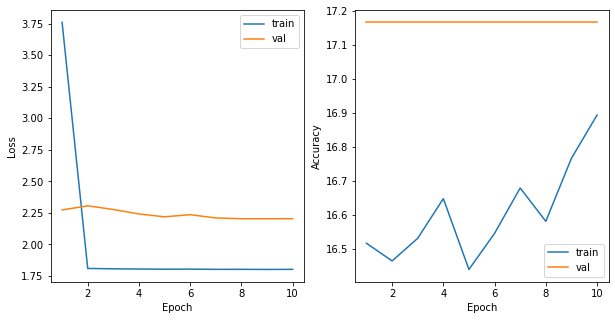

In [5]:
# Create torch dataset from images
class ShapesDataset(torch.utils.data.Dataset):

    def __init__(self, metadata, data_dir, transform=None):
        self.data_dir = data_dir
        self.metadata = pd.read_csv(os.path.join(data_dir, metadata))
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        
        # Read images and targets
        img_path = os.path.join(self.data_dir, self.metadata.iloc[index, 0])
        image = Image.open(img_path)
        label = self.metadata.iloc[index, 1]
        
        # # Convert image to channels first
        # image = np.transpose(image, (2, 0, 1))

        # Transform if requested
        if self.transform:
            image = self.transform(image)

        return image, label

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f'):
        self.name = name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)


class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        print('\t'.join(entries))

    def _get_batch_fmtstr(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'


def save_checkpoint(state, filename):
    torch.save(state, filename)

def cosine_annealing(step, total_steps, lr_max, lr_min): 
    return lr_min + (lr_max - lr_min) * 0.5 * (1 + np.cos(step / total_steps * np.pi))

def accuracy(output, target, topk=(1,)):
    """
    Computes the accuracy over the top k predictions for the specified values of k
    """
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))

        # print("RES array", res)
        return res


def train(train_loader, model, criterion, optimizer, scheduler, epoch, args):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top5],
        prefix="Epoch: [{}]".format(epoch)
    )

    model.train()
    start = time.time()

    for i, (images, target) in enumerate(train_loader):
        data_time.update(time.time() - start)

        x = images.cuda().float()
        y = target.cuda()

        # print(f'**********IMAGE: {x[0]}')
        # print(f'**********TARGET: {y}')
        # print(f'**********TARGET TYPE: {type(y)}')

        logits = model(x)
        # print(f'**********LOGITS: {logits}')
        loss = criterion(logits, y)
        output, target = logits, y 

        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top5.update(acc5[0], images.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        batch_time.update(time.time() - start)

        if i % args.print_freq == 0:
            progress.display(i)

        print('Train * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))
    
    return losses.avg, top1.avg, top5.avg


def val(test_loader, model, criterion, args):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top5 = AverageMeter('Acc@5', ':6.2f')
    progress = ProgressMeter(
        len(test_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: '
    )

    model.eval()

    with torch.no_grad():
        start = time.time()
        for i, (images, target) in enumerate(test_loader):
            images = images.cuda()
            target = target.cuda()

            output = model(images)
            loss = criterion(output, target)
            
            acc1, acc5 = accuracy(output, target, topk=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            batch_time.update(time.time() - start)

            if i % args.print_freq == 0:
                progress.display(i)

        print('Val * Acc@1 {top1.avg:.3f} Acc@5 {top5.avg:.3f}'.format(top1=top1, top5=top5))

    return losses.avg, top1.avg, top5.avg


def main():
    # parser = argparse.ArgumentParser(
    #     description="Trains classifier on shapes dataset", 
    #     formatter_class=argparse.ArgumentDefaultsHelpFormatter
    # )
    # parser.add_argument("--data", "-d", type=str, default="./data/shapes", choices=["./data/shapes"])
    # parser.add_argument("--model", "-m", type=str, default="vgg16")
    # parser.add_argument("--num-workers", type=int, default=2)
    # parser.add_argument("--batch-size", "-b", type=int, default=128)
    # parser.add_argument("--pretrained", "-p", action="store_true")
    # parser.add_argument("--print-freq", "-f", type=int, default=10)
    # # parser.add_argument("--gpu", "-g", action="store_true")
    # parser.add_argument("--epochs", default=10, type=int)
    # parser.add_argument("--save-dir", type=str, default="./checkpoints")
    # # Hyperparams adapted from http://cs231n.stanford.edu/reports/2017/pdfs/420.pdf
    # parser.add_argument("--learning-rate", "-lr", type=float, default=0.001, help="Initial learning rate.")
    # parser.add_argument("--momentum", type=float, default=0.9)
    # parser.add_argument("--decay", "-wd", type=float, default=0.01)
    # args = parser.parse_args()

    # Make args as a class for running in colab
    class Args:
        def __init__(self, data='./images/shapes', model='vgg16', num_workers=2, batch_size=200, pretrained=False, print_freq=10, epochs=10, save_dir='./checkpoints', learning_rate=0.001, momentum=0.9, decay=0.01):
            self.data = data
            self.model = model
            self.num_workers = num_workers
            self.batch_size = batch_size
            self.pretrained = pretrained
            self.print_freq = print_freq
            self.epochs = epochs
            self.save_dir = save_dir
            self.learning_rate = learning_rate
            self.momentum = momentum
            self.decay = decay

    args = Args()


    if args.data == "./images/shapes":
        tub_train_transforms = transforms.Compose([
            # transforms.RandomResizedCrop(224),
            # transforms.RandomRotation(25),
            # transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            # TODO: properly calculate image statistics
            transforms.Normalize([0.5] * 3, [0.5] * 3) 
        ])
        tub_test_transforms = transforms.Compose([
            # transforms.Resize(255), 
            # transforms.CenterCrop(224),
            transforms.ToTensor(),
            # TODO: properly calculate image statistics
            transforms.Normalize([0.5] * 3, [0.5] * 3)
        ])

        # Initialize train, val, test sets
        train_data = ShapesDataset(metadata='metadata_whole.csv', data_dir = args.data, transform = tub_train_transforms)
        val_data = ShapesDataset(metadata='metadata_whole.csv', data_dir = args.data, transform = tub_test_transforms)
        test_data = ShapesDataset(metadata='metadata_whole.csv', data_dir = args.data, transform = tub_test_transforms)
        
        # Get train, val, test splits
        train_size = 0.8
        total_num_train = len(train_data.metadata)
        indices = np.random.permutation(list(range(total_num_train)))
        split = int(np.floor(train_size * total_num_train))
        val_split = int(np.floor((train_size + (1 - train_size) / 2) * total_num_train))
        train_idx, val_idx, test_idx = indices[:split], indices[split:val_split], indices[val_split:]
        
        # Subset train, val, test sets
        train_data = torch.utils.data.Subset(train_data, indices=train_idx)
        val_data = torch.utils.data.Subset(val_data, indices=val_idx)
        test_data = torch.utils.data.Subset(test_data, indices=test_idx)

    else:
        raise Exception(f"{args.data} is not a supported dataset")

    train_loader = torch.utils.data.DataLoader(
        train_data, 
        batch_size=args.batch_size,
        num_workers=args.num_workers, 
        shuffle=True,
        # Unclear if we need drop_last, e.g. AugMix doesn't have this
        drop_last=True)

    val_loader = torch.utils.data.DataLoader(
        val_data, 
        batch_size=args.batch_size,
        num_workers=args.num_workers, 
        shuffle=True,
        # Unclear if we need drop_last, e.g. AugMix doesn't have this
        drop_last=True)

    test_loader = torch.utils.data.DataLoader(
        test_data, 
        batch_size=args.batch_size,
        num_workers=args.num_workers, 
        shuffle=True,
        # Unclear if we need drop_last, e.g. AugMix doesn't have this
        drop_last=True)

    if args.model == "vgg16":
        model = models.vgg16(pretrained=args.pretrained)
        features = []
        for feat in list(model.features):
            features.append(feat)
            if isinstance(feat, nn.Conv2d):
                features.append(nn.Dropout(p=0.5, inplace=True))

        model.features = nn.Sequential(*features)
    else:
        raise Exception(f"{args.model} is not a supported model")


    model = torch.nn.DataParallel(model).cuda()
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.SGD(
        model.parameters(),
        args.learning_rate,
        momentum=args.momentum,
        weight_decay=args.decay,
        nesterov=True
    )

    scheduler = torch.optim.lr_scheduler.LambdaLR(
        optimizer,
        lr_lambda=lambda step: cosine_annealing( 
            step,
            args.epochs * len(train_loader),
            1,  
            1e-6 / args.learning_rate
        )
    )

    # MAIN TRAINING LOOP
    best_acc1 = 0
    for epoch in range(args.epochs):
        train_losses_avg, train_top1_avg, train_top5_avg = train(train_loader, model, criterion, optimizer, scheduler, epoch, args)
        val_losses_avg, val_top1_avg, val_top5_avg = val(val_loader, model, criterion, args)

        os.makedirs(args.save_dir, exist_ok = True)          
        with open(os.path.join(args.save_dir, "training_log.csv"), "a+") as f:
          f.write(f'{(epoch + 1)},{train_losses_avg},{train_top1_avg},{train_top5_avg},{val_losses_avg},{val_top1_avg},{val_top5_avg}\n')

        best_acc1 = max(val_top5_avg, best_acc1)
        save_file = os.path.join(args.save_dir, "final_model.pth")
        save_checkpoint({
            'epoch': epoch + 1,
            'arch': args.model,
            'state_dict': model.state_dict(),
            'best_acc1': best_acc1,
            'optimizer' : optimizer.state_dict(),
        }, filename=save_file)

    best_cp = torch.load(save_file)
    model.load_state_dict(best_cp["state_dict"])
    test_losses_avgs, test_top1_avg, test_top5_avg = val(test_loader, model, criterion, args)
    print(f'Test * Acc@1 {test_top1_avg} Acc@5 {test_top5_avg}')

    # Plot training curves
    df = pd.read_csv(os.path.join(args.save_dir, "training_log.csv"), header=None)
    df.columns = ['epoch', 'train_loss', 'train_acc1', 'train_acc5', 'val_loss', 'val_acc1', 'val_acc5']

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train_loss'], label='train')
    plt.plot(df['epoch'], df['val_loss'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['train_acc1'], label='train')
    plt.plot(df['epoch'], df['val_acc1'], label='val')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
if __name__ == "__main__":
    main()